In [2]:
import sys
sys.path.append('../external/database-manager/')
import dbmanager as dm

import matplotlib.pyplot as plt
from IPython.display import clear_output
    
sys.path.append('../external/rupturehunter/')
sys.path.append('../external/')
import rupturehunter as rh
import solidmechanics as sm
import solidmechanics.lefm as lefm

import fenics as fe

from helper_functions import *

## Color map for large and small strains

In [3]:
small_strain_hex = ['#dde6cc', '#a8bb89', '#749149']
large_strain_hex = ['#ecddf6', '#b092c5', '#744c96']

In [4]:
def cmap_small_strain():
    import matplotlib.colors
    small_strain_rgb = []
    for hex in small_strain_hex:
        small_strain_rgb.append(matplotlib.colors.to_rgb(hex))
    
    from matplotlib.colors import LinearSegmentedColormap
    v = [0, 0.33, 1.0]
    l = list(zip(v,small_strain_rgb))
    greens = LinearSegmentedColormap.from_list('Hot and Cold',l, N=256)
    return greens

def cmap_large_strain():
    import matplotlib.colors
    large_strain_rgb = []
    for hex in large_strain_hex:
        large_strain_rgb.append(matplotlib.colors.to_rgb(hex))
    
    from matplotlib.colors import LinearSegmentedColormap
    v = [0, 0.33, 1.0]
    l = list(zip(v,large_strain_rgb))
    blues = LinearSegmentedColormap.from_list('Hot and Cold',l, N=256)
    return blues

cmap_blues = cmap_large_strain()
cmap_greens = cmap_small_strain()

In [5]:
copy_data_for_plotting = True

## Reading data 

We now read the simulated data. For this we use the external dependency `database-manager`. 

To read the data provided in the ETH Research collection, just replace the variable `path` with the path location where data is stored locally and replace the `nonlinear` with folder name where the data is located. 


In [6]:
path = '../output/'
schema = dm.Digger(path, 'nonlinear')
df = schema.showParametericSpace(shell_display=False)
df.loc[:, ~df.columns.isin(['path', 'schema'])]

E  Gamma  alpha deformations  height_factor  \
0  106000.0   15.0  200.0        small           20.0   
1  106000.0   15.0  200.0        large           20.0   

                                idx  length_factor material_law        mesh  \
0  7afbd4ff30474c3bbf6be62b6a382e1a           25.0       linear  structured   
1  70dd1d94827947aaaca7fe3a98432eac           25.0       linear  structured   

   nb_elem_coh  poisson  prefactor  prestrain     rho  sigma_c  time  \
0         30.0     0.35        1.0      0.125  1025.0  20000.0  0.06   
1         30.0     0.35        1.0      0.125  1025.0  20000.0  0.06   

   time_factor  
0         0.05  
1         0.05

We select the two simulation one with small deformations and the opther with geometric non-linearities and read the data for a prestrain of `0.125` which is equal to a stretch of `1.125`.

In [7]:
deformations = ['small', 'large']
job_id = {}
for deform in deformations:
    print(deform)
    job_id[deform] = schema.job.digID({'deformations' : deform, 'prestrain' : 0.125 })[0]
    print(schema.job.showDatabaseSpace(job_id[deform], shell_display=True))

small
Data Quantities in for Job | 7afbd4ff30474c3bbf6be62b6a382e1a 
+----+------------+------------------+------------------+------------+-----------------+---------------+-----------+----------------+-------------+--------------------+---------------------+
|    | coords.x   | energy.elastic   | energy.kinetic   | gap.ctod   | gap.effective   | gap.maximum   | timings   | tip.cohesive   | tip.crack   | tractions.actual   | tractions.applied   |
|----+------------+------------------+------------------+------------+-----------------+---------------+-----------+----------------+-------------+--------------------+---------------------|
|  0 | float64    | float64          | float64          | float64    | float64         | float64       | float64   | float64        | float64     | float64            | float64             |
|  1 | (458, 0)   | (458,)           | (458,)           | (458, 0)   | (458, 0)        | (458, 0)      | (458,)    | (458, 0)       | (458, 0)    | (458, 0)           

In [11]:
output_fields = ['coords.x',  'timings', 'gap.ctod', 'tractions.actual',
                 'tip.crack',  'tip.cohesive']

schema.job.steps_to_retrive = list(range(0, 95000, 1))
results = {}
for key, value in job_id.items():
    results[key] = schema.job.digQuantitiesForJob(output_fields, value, copy=copy_data_for_plotting)

small
large


## Plotting space-time diagram

In [12]:
matprop = sm.LinearElasticMaterial({sm.smd.E:  schema.job.digParameterValue('E', job_id['small']), 
                                    sm.smd.nu: schema.job.digParameterValue('poisson', job_id['small']), 
                                    sm.smd.rho: schema.job.digParameterValue('rho', job_id['small']), 
                                    sm.smd.pstrain:True})

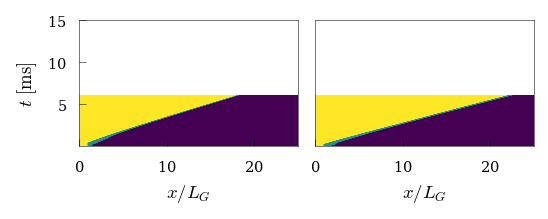

In [46]:
# plot
fig = plt.figure(figsize=set_size( width='one-column'), constrained_layout=True)

gs = fig.add_gridspec(2, 2, wspace=0.01, hspace=0.0001)
ax = fig.add_subplot(gs[1, 0])
plot_space_time_cohesive(ax, results=results['small'], job_id=job_id['small'])

ax.set_xlim(right=25)
ax.set_ylim(top=15)
ax.set_xlabel(r'$ x/L_G$')
ax.set_ylabel(r'$t~\mathrm{[ms]}$')


ax = fig.add_subplot(gs[1, 1])
plot_space_time_cohesive(ax, results=results['large'], job_id=job_id['large'])
ax.axes.get_yaxis().set_visible(False)

ax.set_xlim(right=25)
ax.set_ylim(top=15)
ax.set_xlabel(r'$ x/L_G$')

#plt.savefig('../figures/figure_1.svg', format='svg', dpi=600)
plt.show()

## Cohesive zone vs. Rupture speed

In [14]:
def moving_average(arr,  window_size=3):
    i = 0
    # Initialize an empty list to store moving averages
    moving_averages = []
  
    # Loop through the array to consider
    # every window of size 3
    while i < len(arr) - window_size + 1:
    
        # Store elements from i to i+window_size
        # in list to get the current window
        window = arr[i : i + window_size]
  
        # Calculate the average of current window
        window_average = round(sum(window) / window_size, 2)
      
        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)
      
        # Shift window to right by one position
        i += 1
        
    return np.asarray(moving_averages)


In [15]:
def plot_cohesive_zone_size(ax, results, job_id, color, tip='cohesive', deform='small', marker='o', markevery=5, ms=5):
    matprop = sm.LinearElasticMaterial({sm.smd.E:  schema.job.digParameterValue('E', job_id), 
                                    sm.smd.nu: schema.job.digParameterValue('poisson', job_id), 
                                    sm.smd.rho: schema.job.digParameterValue('rho', job_id), 
                                    sm.smd.pstress:False})
    iface = {sm.smd.Gamma : schema.job.digParameterValue('Gamma', job_id),
             sm.smd.tauc : schema.job.digParameterValue('sigma_c', job_id), sm.smd.taur : 0 }
 
    
    indexes = np.argsort(results['coords.x'][0])
    griffiths_length = get_griffiths_length(job_id)
    
    coordinates_along_interface = results['coords.x'][0, indexes].reshape(-1)  
    
    normalized_coordinates = coordinates_along_interface/griffiths_length
    #cut_off_index = np.where(normalized_coordinates > 15)[0][0]

    min_length = np.minimum(results['tip.crack'][:, indexes].shape[0], results['tip.cohesive'][:, indexes].shape[0])
    
    crack_map = 1-results['tip.crack'][:min_length, indexes] + results['tip.cohesive'][:min_length, indexes]
    
    if tip == 'cohesive':
        openings_bool = results['tip.cohesive'][:, indexes] == 0
    elif tip == 'crack':
        openings_bool = results['tip.crack'][:, indexes] == 1

    nb_steps = openings_bool.shape[0]

  
    hunter = rh.RuptureHunter()
    hunter.load(results['coords.x'][0, indexes].reshape(1, len(results['coords.x'][0, :])), results['timings'][:nb_steps], 
                openings_bool[:nb_steps, :])
    hunter.hunt()
    rupture = hunter.get_rupture(hunter.get_rupture_indexes()[0])
    front = rupture.get_sorted_front()
    
    factor = 1.5
    if deform == 'large':
        factor = 3
        
    speed = rupture.get_propagation_speed(avg_dist=factor*griffiths_length)

    static_cohesive_zone_size = get_static_cohesive_zone_size(results, job_id)
    
    cohesive_zone_starts = np.ma.array(results['coords.x'][:, indexes], mask=crack_map!=1)
    
    cohesive_zone_size = (np.max(cohesive_zone_starts, axis=1) - np.min(cohesive_zone_starts, axis=1))/static_cohesive_zone_size
    rupture_speed = []
    rupture_cohesive_size = [] 
    analytical_cohesive_zone = []
    
    x_lc = np.max(cohesive_zone_starts, axis=1)
    
    cut_off_length  = 25
    if deform == 'large':
        cut_off_length = 15
    
    
    for xlc, cs in  zip(speed[:, 0], speed[:, 2]):
        if xlc/griffiths_length > cut_off_length:
            continue
        xlc_index = np.where( xlc  >= x_lc.data)[0][-1]
        rupture_speed.append(cs)
        rupture_cohesive_size.append(cohesive_zone_size[xlc_index])
    
    rupture_cohesive_size = np.asarray(rupture_cohesive_size).round(decimals=4)
    
    unique_speed = np.asarray(rupture_speed)
    unique_cohesive_zone = []
    for cz in unique_speed:
        index = np.argwhere(np.asarray(rupture_speed) == cz)
        unique_cohesive_zone.append(np.mean(np.asarray(rupture_cohesive_size)[index]))
              
    if deform == 'large':
        analytical_speed = np.linspace(0, matprop[sm.smd.cR]-1e-3, 100)
        for css in analytical_speed:
            analytical_cohesive_zone.append(lefm.cohesive_zone.compute_Xc(matprop, iface, css, mode=1))
    
    ax.plot( np.asarray(unique_speed)/matprop[sm.smd.cR], unique_cohesive_zone, marker,
            ms=ms, markeredgecolor='k', markeredgewidth=0.3, markerfacecolor=color, markevery=markevery, zorder=10)
    
    if deform == 'large':
        ax.plot(np.asarray(analytical_speed)/matprop[sm.smd.cR], 
                np.asarray(analytical_cohesive_zone)/static_cohesive_zone_size, color='xkcd:coral', zorder=2)
        
        ax.axvline(1, color='lightgrey', ls='dashdot', zorder=1)
        ax.axvline(matprop[sm.smd.cs]/matprop[sm.smd.cR], color='lightgrey', ls='dashdot', zorder=1)
        
    return np.asarray(unique_speed)/matprop[sm.smd.cR], unique_cohesive_zone

In [27]:
df = schema.showParametericSpace(shell_display=False)
df.loc[:, ~df.columns.isin(['path', 'schema'])]

E  Gamma  alpha deformations  height_factor  \
0   106000.0   15.0  200.0        small           20.0   
1   106000.0   15.0  200.0        large           20.0   
2   106000.0   15.0  200.0        small           20.0   
3   106000.0   15.0  200.0        small           20.0   
4   106000.0   15.0  200.0        large           20.0   
5   106000.0   15.0  200.0        large           20.0   
6   106000.0   15.0  200.0        small           20.0   
7   106000.0   15.0  200.0        large           20.0   
8   106000.0   15.0  200.0        small           20.0   
9   106000.0   15.0  200.0        large           20.0   
10  106000.0   15.0  200.0        small           20.0   
11  106000.0   15.0  200.0        large           20.0   

                                 idx  length_factor material_law        mesh  \
0   dafdbcc2d00b4a3f88173bcf67e2ea68           30.0       linear  structured   
1   dc4a19f28904436b9bd44194b132001d           30.0       linear  structured   
2   c396eb06cc774e19ac429fcca37b24c0           30.0       linear  structured   
3   7ead33ebf0754a1ba106c362442b20b5           30.0       linear  structured   
4   04f8626841c04646b2beea7182310f6d           30.0       linear  structured   
5   18cd219c674d4c2ea7d6cd6e5e7f6c9f           30.0       linear  structured   
6   eeb1b9aa9d6340d5861bbce20f478749           30.0       linear  structured   
7   95ede6dead94491eaefa5bcb984c2adc           30.0       linear  structured   
8   5628734b9279486a9b032a5897cca459           30.0       linear  structured   
9   da921484571a41949b78e5c7f996236c           30.0       linear  structured   
10  61cd2b5a3cde43e591d0cf48970730eb           30.0       linear  structured   
11  800fc2f1cf9642cb962c2a425437a2e7           30.0       linear  structured   

    nb_elem_coh  poisson  prefactor  prestrain     rho  sigma_c  time  \
0          20.0     0.35        1.0     0.1000  1025.0  20000.0  0.06   
1          20.0     0.35        1.0     0.1000  1025.0  20000.0  0.06   
2          30.0     0.35        1.0     0.1000  1025.0  20000.0  0.06   
3          30.0     0.35        1.0     0.0875  1025.0  20000.0  0.06   
4          30.0     0.35        1.0     0.1000  1025.0  20000.0  0.06   
5          20.0     0.35        1.0     0.0875  1025.0  20000.0  0.06   
6          20.0     0.35        1.0     0.1250  1025.0  20000.0  0.06   
7          30.0     0.35        1.0     0.0875  1025.0  20000.0  0.06   
8          30.0     0.35        1.0     0.1250  1025.0  20000.0  0.06   
9          20.0     0.35        1.0     0.1250  1025.0  20000.0  0.06   
10         20.0     0.35        1.0     0.0875  1025.0  20000.0  0.06   
11         30.0     0.35        1.0     0.1250  1025.0  20000.0  0.06   

    time_factor  
0          0.05  
1          0.05  
2          0.05  
3          0.05  
4          0.05  
5          0.05  
6          0.05  
7          0.05  
8          0.05  
9          0.05  
10         0.05  
11         0.05

In [28]:
deformations = ['large', 'small']
job_id = {}
for deform in deformations:
    print(deform)
    job_id[deform] = schema.job.digID({'poisson' : 0.35, 'sigma_c' : 2e4, 'length_factor' :30, 
                                       'prestrain' : 0.125, 'prefactor' : 1,  'nb_elem_coh' : 30,
                                       'deformations' : deform, 'material_law' : 'linear',
                                       'time_factor' : 0.05, 'alpha' : 200,
                                       'mesh' : 'structured'})[0]
    print(schema.job.showDatabaseSpace(job_id[deform], shell_display=True))

large
Data Quantities in for Job | 800fc2f1cf9642cb962c2a425437a2e7 
+----+-------------+------------------+------------------+-------------+-----------------+---------------+-----------+----------------+-------------+--------------------+---------------------+
|    | coords.x    | energy.elastic   | energy.kinetic   | gap.ctod    | gap.effective   | gap.maximum   | timings   | tip.cohesive   | tip.crack   | tractions.actual   | tractions.applied   |
|----+-------------+------------------+------------------+-------------+-----------------+---------------+-----------+----------------+-------------+--------------------+---------------------|
|  0 | float64     | float64          | float64          | float64     | float64         | float64       | float64   | float64        | float64     | float64            | float64             |
|  1 | (200200, 0) | (200200,)        | (200200,)        | (200200, 0) | (200200, 0)     | (200200, 0)   | (200200,) | (200200, 0)    | (200200, 0) | (200200, 

In [29]:
output_fields = ['coords.x',  'timings', 'gap.ctod', 'tractions.actual',
                 'tip.crack',  'tip.cohesive']

schema.job.steps_to_retrive = list(range(5000, 70000, 1))
results = {}
for key, value in job_id.items():
    if key == 'large':
        schema.job.steps_to_retrive = list(range(5000, 90000, 1))
    else:
        schema.job.steps_to_retrive = list(range(5000, 90000, 1))

    results[key] = schema.job.digQuantitiesForJob(output_fields, value, copy=copy_data_for_plotting)

large
small


 - RUPTURE HUNTER
   * Load
     * Position 714/714
   * Hunt
 - RUPTURE HUNTER
   * Load
     * Position 714/714
   * Hunt


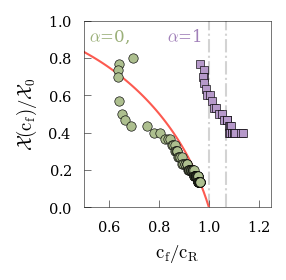

In [34]:
fig = plt.figure(figsize=set_size( width='two-column', fraction=0.25, height_ratio=1), constrained_layout=True)
gs = fig.add_gridspec(1, 1)
colors = {}
colors['small'] = cmap_greens(0.3)
colors['large'] = cmap_blues(0.3)

marker ={}
marker['small'] = 'o'
marker['large'] = 's'

markevery ={}
markevery['small'] = 5
markevery['large'] = 8


marksize ={}
marksize['small'] = 4.5
marksize['large'] = 4.25


ax = fig.add_subplot(gs[0, 0])
for deform in deformations:
    plot_cohesive_zone_size(ax, results=results[deform], job_id=job_id[deform], color=colors[deform], deform=deform, marker=marker[deform], markevery=markevery[deform], ms=marksize[deform])
ax.set_ylabel(r'$ \mathcal{X}(\mathrm{c_f})/\mathcal{X}_0$')
ax.set_xlabel(r'$\mathrm{c_f/c_R}$')
ax.set_xlim(left=0.5, right=1.25)
ax.set_ylim(0, 1)
ax.set_aspect(1./ax.get_data_ratio())

ax.text(0.6, 0.91, r'$\alpha$=0,', color=cmap_greens(0.5), horizontalalignment='center',
     verticalalignment='center', transform=ax.transData, fontsize=8)
ax.text(0.9, 0.91, r'$\alpha$=1', color=cmap_blues(0.5), horizontalalignment='center',
     verticalalignment='center', transform=ax.transData, fontsize=8)

plt.show()

## Crack tip morphologies

In [16]:
def plot_tip_morphology(ax, results, job_id, color, step_number, tip='crack', ls='-'):
   
    indexes = np.argsort(results['coords.x'][0])
    if tip == 'crack':
        tip_index = np.where(results['tip.crack'][step_number, indexes] > 0)[0][0]
        #tip_index = np.where(results['gap.ctod'][step_number, indexes] < 2e-3)[0][0]
        x_lc = results['coords.x'][0, indexes[np.where(results['tip.crack'][step_number, indexes] == 1)[0][0]]]
        openings_bool = results['tip.crack'][:, indexes] == 1
    elif tip == 'cohesive':
        tip_index = np.where(results['tip.cohesive'][step_number, indexes] < 1)[0][0]
        x_lc = results['coords.x'][0, indexes[np.where(results['tip.cohesive'][step_number, indexes] == 0)[0][0]]]
        openings_bool = results['tip.cohesive'][:, indexes] == 0
    
            
    tip_coord = results['coords.x'][0, indexes][tip_index]

    coordinates_along_interface = results['coords.x'][0, indexes].reshape(-1)  - tip_coord
    griffiths_length = get_griffiths_length(job_id)
   
    normalized_coordinates_along_interface = coordinates_along_interface/griffiths_length
    
        
    matprop = sm.LinearElasticMaterial({sm.smd.E:  schema.job.digParameterValue('E', job_id), 
                                    sm.smd.nu: schema.job.digParameterValue('poisson', job_id), 
                                    sm.smd.rho: schema.job.digParameterValue('rho', job_id), 
                                    sm.smd.pstress:False})
  
        
    nb_steps = openings_bool.shape[0]
  
    hunter = rh.RuptureHunter()
    hunter.load(results['coords.x'][0, indexes].reshape(1, len(results['coords.x'][0, :])), results['timings'][:nb_steps], 
                openings_bool[:nb_steps, :])
    hunter.hunt()
    rupture = hunter.get_rupture(hunter.get_rupture_indexes()[0])
    front = rupture.get_sorted_front()
    
    speed = rupture.get_propagation_speed(avg_dist=1.5*griffiths_length)
    
    x_lc_index = np.where(speed[:, 0] >= x_lc)[0][0]

    print(np.round(speed[x_lc_index, 2]/matprop[sm.smd.cR], 2))
    ax.plot(normalized_coordinates_along_interface, results['gap.ctod'][step_number, indexes]/griffiths_length,
            color=color, lw=1.25, ls=ls)
    
    min_length = np.minimum(results['tip.crack'][step_number, indexes].shape[0], results['tip.cohesive'][step_number, indexes].shape[0])
    crack_map = 1-results['tip.crack'][step_number, indexes] + results['tip.cohesive'][step_number, indexes]
    cohesive_zone_starts = np.ma.array(results['coords.x'][step_number, indexes], mask=crack_map!=1)
    cohesive_zone_size = -(np.max(cohesive_zone_starts) - np.min(cohesive_zone_starts))/griffiths_length
    
 
    index = np.where(normalized_coordinates_along_interface < cohesive_zone_size)[0][-1]
    
    ax.scatter(cohesive_zone_size, results['gap.ctod'][step_number, indexes][index]/griffiths_length, s=20,
               color=np.asarray(color), edgecolors='k', linewidths=0.4, marker='X', zorder=20)

    
    return np.round(speed[x_lc_index, 2]/matprop[sm.smd.cR], 2)

In [17]:
def plot_tip_relation(ax, results, job_id, color, step_number, tip='crack', marker='o', ls='-'):
    indexes = np.argsort(results['coords.x'][0])
    if tip == 'crack':
        tip_index = np.where(results['tip.crack'][step_number, indexes] > 0)[0][0]
        x_lc = results['coords.x'][0, indexes[np.where(results['tip.crack'][step_number, indexes] == 1)[0][0]]]
        openings_bool = results['tip.crack'][:, indexes] == 1
    elif tip == 'cohesive':
        tip_index = np.where(results['tip.cohesive'][step_number, indexes] < 1)[0][0]
        x_lc = results['coords.x'][0, indexes[np.where(results['tip.cohesive'][step_number, indexes] == 0)[0][0]]]
        openings_bool = results['tip.cohesive'][:, indexes] == 0
    
            
    tip_coord = results['coords.x'][0, indexes][tip_index]

    coordinates_along_interface = results['coords.x'][0, indexes].reshape(-1)  - tip_coord
    griffiths_length = get_griffiths_length(job_id)
   
    normalized_coordinates_along_interface = coordinates_along_interface/griffiths_length
    
        
    matprop = sm.LinearElasticMaterial({sm.smd.E:  schema.job.digParameterValue('E', job_id), 
                                    sm.smd.nu: schema.job.digParameterValue('poisson', job_id), 
                                    sm.smd.rho: schema.job.digParameterValue('rho', job_id), 
                                    sm.smd.pstress:False})
  
        
    nb_steps = openings_bool.shape[0]
  
    hunter = rh.RuptureHunter()
    hunter.load(results['coords.x'][0, indexes].reshape(1, len(results['coords.x'][0, :])), results['timings'][:nb_steps], 
                openings_bool[:nb_steps, :])
    hunter.hunt()
    rupture = hunter.get_rupture(hunter.get_rupture_indexes()[0])
    front = rupture.get_sorted_front()
    
    speed = rupture.get_propagation_speed(avg_dist=1.5*griffiths_length)
    
    x_lc_index = np.where(speed[:, 0] >= x_lc)[0][0]
    
    
    delta_max = 1e-3
    cut_off_index = np.where(normalized_coordinates_along_interface > -30)[0][0]
            
    xx = -normalized_coordinates_along_interface[cut_off_index:]
    yy = results['gap.ctod'][step_number, indexes][cut_off_index:]
    
  
    delta_index = np.where(yy < delta_max)[0][0]
    
    ax.loglog(xx[:delta_index], yy[:delta_index]/griffiths_length,
              color=color, lw=1.25, ls=ls, marker=marker, markevery=4,
            ms=3, markeredgecolor='k', markeredgewidth=0.1, markerfacecolor=color)


In [72]:
df = schema.showParametericSpace(shell_display=False)
df.loc[:, ~df.columns.isin(['path', 'schema'])]

E  Gamma  alpha deformations  height_factor  \
0   106000.0   15.0  200.0        small           20.0   
1   106000.0   15.0  200.0        large           20.0   
2   106000.0   15.0  200.0        small           20.0   
3   106000.0   15.0  200.0        small           20.0   
4   106000.0   15.0  200.0        large           20.0   
5   106000.0   15.0  200.0        large           20.0   
6   106000.0   15.0  200.0        small           20.0   
7   106000.0   15.0  200.0        large           20.0   
8   106000.0   15.0  200.0        small           20.0   
9   106000.0   15.0  200.0        large           20.0   
10  106000.0   15.0  200.0        small           20.0   
11  106000.0   15.0  200.0        large           20.0   

                                 idx  length_factor material_law        mesh  \
0   dafdbcc2d00b4a3f88173bcf67e2ea68           30.0       linear  structured   
1   dc4a19f28904436b9bd44194b132001d           30.0       linear  structured   
2   c396eb06cc774e19ac429fcca37b24c0           30.0       linear  structured   
3   7ead33ebf0754a1ba106c362442b20b5           30.0       linear  structured   
4   04f8626841c04646b2beea7182310f6d           30.0       linear  structured   
5   18cd219c674d4c2ea7d6cd6e5e7f6c9f           30.0       linear  structured   
6   eeb1b9aa9d6340d5861bbce20f478749           30.0       linear  structured   
7   95ede6dead94491eaefa5bcb984c2adc           30.0       linear  structured   
8   5628734b9279486a9b032a5897cca459           30.0       linear  structured   
9   da921484571a41949b78e5c7f996236c           30.0       linear  structured   
10  61cd2b5a3cde43e591d0cf48970730eb           30.0       linear  structured   
11  800fc2f1cf9642cb962c2a425437a2e7           30.0       linear  structured   

    nb_elem_coh  poisson  prefactor  prestrain     rho  sigma_c  time  \
0          20.0     0.35        1.0     0.1000  1025.0  20000.0  0.06   
1          20.0     0.35        1.0     0.1000  1025.0  20000.0  0.06   
2          30.0     0.35        1.0     0.1000  1025.0  20000.0  0.06   
3          30.0     0.35        1.0     0.0875  1025.0  20000.0  0.06   
4          30.0     0.35        1.0     0.1000  1025.0  20000.0  0.06   
5          20.0     0.35        1.0     0.0875  1025.0  20000.0  0.06   
6          20.0     0.35        1.0     0.1250  1025.0  20000.0  0.06   
7          30.0     0.35        1.0     0.0875  1025.0  20000.0  0.06   
8          30.0     0.35        1.0     0.1250  1025.0  20000.0  0.06   
9          20.0     0.35        1.0     0.1250  1025.0  20000.0  0.06   
10         20.0     0.35        1.0     0.0875  1025.0  20000.0  0.06   
11         30.0     0.35        1.0     0.1250  1025.0  20000.0  0.06   

    time_factor  
0          0.05  
1          0.05  
2          0.05  
3          0.05  
4          0.05  
5          0.05  
6          0.05  
7          0.05  
8          0.05  
9          0.05  
10         0.05  
11         0.05

In [73]:
deformations = ['large', 'small']
job_id = {}
for deform in deformations:
    print(deform)
    job_id[deform] = schema.job.digID({'poisson' : 0.35, 'sigma_c' : 2e4, 'length_factor' :30, 
                                       'prestrain' : 0.1, 'prefactor' : 1,  'nb_elem_coh' : 20,
                                       'deformations' : deform, 'material_law' : 'linear',
                                       'time_factor' : 0.05, 'alpha' : 200,
                                       'mesh' : 'structured'})[0]

large
small


In [74]:
output_fields = ['coords.x',  'timings', 'gap.ctod', 'gap.effective',
                 'tip.crack',  'tip.cohesive']

schema.job.steps_to_retrive = list(range(0, 80000, 1))
results = {}
for key, value in job_id.items():
    results[key] = schema.job.digQuantitiesForJob(output_fields, value, copy=copy_data_for_plotting)
    print(key)

large
small


In [75]:
griffiths_length = get_griffiths_length(job_id['large'])

 - RUPTURE HUNTER
   * Load
     * Position 743/743
   * Hunt
1.07
-0.31224764468257044
254
 - RUPTURE HUNTER
   * Load
     * Position 743/743
   * Hunt
0.92
-0.15612382234129943
178
 - RUPTURE HUNTER
   * Load
     * Position 743/743
   * Hunt
0.94
-0.46837146702453764
86
 - RUPTURE HUNTER
   * Load
     * Position 743/743
   * Hunt
 - RUPTURE HUNTER
   * Load
     * Position 743/743
   * Hunt
 - RUPTURE HUNTER
   * Load
     * Position 743/743
   * Hunt


/cluster/home/mpundir/.local/lib/python3.8/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_line0), but could not find a label for it.
  warnings.warn(
/cluster/home/mpundir/.local/lib/python3.8/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_line1), but could not find a label for it.
  warnings.warn(
/cluster/home/mpundir/.local/lib/python3.8/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_line2), but could not find a label for it.
  warnings.warn(


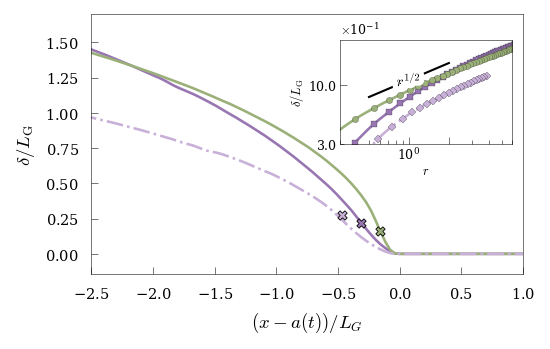

In [78]:
fig = plt.figure(figsize=set_size(width='one-column', height_ratio='golden'), constrained_layout=True)
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0, 0])
colors = {}
colors['small'] = cmap_greens(0.5)
colors['large'] = cmap_blues(0.6)

step_number = {}
step_number['small'] = 65000 # 40000 for 1.125 30 elements
step_number['large'] = 72500 # 40000 for 1.125 30 elements


crack_speed = {}

for deform in deformations:
    crack_speed[deform] = plot_tip_morphology(ax, results=results[deform], job_id=job_id[deform], color=colors[deform], 
                            step_number=step_number[deform], tip='cohesive')


step_number['large'] = 30000 # 175000
crack_speed['large'] = plot_tip_morphology(ax, results=results['large'], job_id=job_id['large'], color=cmap_blues(0.2), 
                            step_number=step_number['large'], tip='cohesive', ls='dashdot')

    
ax.set_xlabel(r'$(x- a(t))/L_G$')
ax.set_ylabel(r'$\delta/L_\mathrm{G}$')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-3,4))
ax.set_xlim(left=-2.5, right=1)

step_number['small'] = 65000 # 40000 for 1.125 30 elements
step_number['large'] = 72500 # 27500 for 1.125 30 elements

marker ={}
marker['small'] = 'o'
marker['large'] = 's'
axins = ax.inset_axes([0.575, 0.5, 0.4, 0.4])
for deform in deformations:
    plot_tip_relation(axins, results=results[deform], job_id=job_id[deform], color=colors[deform], 
                      step_number=step_number[deform], tip='cohesive', marker=marker[deform])
    
step_number['large'] = 30000 #17500
plot_tip_relation(axins, results=results['large'], job_id=job_id['large'], color=cmap_blues(0.2), 
                      step_number=step_number['large'], tip='cohesive', ls='dashdot', marker='D')
    
    
xx = np.linspace(0.5, 2)
axins.loglog(xx, np.power(xx, 1/2)*2*2.85e-3/griffiths_length, 
           color='k', label=r'$ r^{1/2}$')

labelLines(axins.get_lines(), xvals=(1),  zorder=2.5, align=False)
axins.set_yticks(ticks=[3e-1, 10e-1], minor=True)

axins.set_xticks([1, 2])
axins.yaxis.set_major_formatter(OOMFormatter(-1))
axins.yaxis.set_minor_formatter(OOMFormatter(-1))

                    
axins.set_ylabel(r'$\delta/L_\mathrm{G}$', fontsize=6, labelpad=1)
axins.set_xlabel(r'$r$', fontsize=6, labelpad=1)
axins.set_ylim(bottom=3e-1, top=2.5)
axins.set_xlim(0.3, 6)
axins.xaxis.set_tick_params(labelsize=6, which='both', pad=1)
axins.yaxis.set_tick_params(labelsize=6, which='both', pad=1)
axins.yaxis.offsetText.set_fontsize(6)
ax.set_ylim(top=1.7)
plt.show()

## Crack speed dynamics vs Applied stretch

In [18]:
df = schema.showParametericSpace(shell_display=False)
df.loc[:, ~df.columns.isin(['path', 'schema', 'idx'])]

E  Gamma  alpha deformations  height_factor  length_factor  \
0  106000.0    8.0  200.0        small           20.0           30.0   
1  106000.0    8.0  200.0        large           20.0           30.0   
2  106000.0    8.0  200.0        large           20.0           30.0   
3  106000.0    8.0  200.0        large           20.0           30.0   
4  106000.0    8.0  200.0        small           20.0           30.0   
5  106000.0    8.0  200.0        small           20.0           30.0   
6  106000.0    8.0  200.0        large           20.0           30.0   
7  106000.0    8.0  200.0        small           20.0           30.0   

  material_law        mesh  nb_elem_coh  poisson  prefactor  prestrain  \
0       linear  structured         20.0     0.35        1.0     0.1000   
1       linear  structured         20.0     0.35        1.0     0.1250   
2       linear  structured         20.0     0.35        1.0     0.0875   
3       linear  structured         20.0     0.35        1.0     0.1000   
4       linear  structured         20.0     0.35        1.0     0.1250   
5       linear  structured         30.0     0.35        1.0     0.1250   
6       linear  structured         30.0     0.35        1.0     0.1250   
7       linear  structured         20.0     0.35        1.0     0.0875   

      rho  sigma_c  time  time_factor  
0  1025.0  20000.0  0.06         0.05  
1  1025.0  20000.0  0.06         0.05  
2  1025.0  20000.0  0.06         0.05  
3  1025.0  20000.0  0.06         0.05  
4  1025.0  20000.0  0.06         0.05  
5  1025.0  20000.0  0.06         0.05  
6  1025.0  20000.0  0.06         0.05  
7  1025.0  20000.0  0.06         0.05

In [19]:
strains = [0.0875, 0.1, 0.125]
deformations = ['large', 'small']
job_id = {}
nb_steps = {}

for deform in deformations:
    job_id[deform] = {}
    nb_steps[deform] = {}
    for strain in strains:
        print(strain)
        length_factor = 30            
        nb_elem = 20
        if strain == 0.125:
            nb_elem = 30
        time_factor = 0.05
        
        job_id[deform][strain] = schema.job.digID({'poisson' : 0.35, 'sigma_c' : 2e4, 'length_factor' :length_factor, 
                                           'prestrain' : strain, 'prefactor' : 1,  'nb_elem_coh' : nb_elem,
                                           'deformations' : deform, 'material_law' : 'linear',
                                           'time_factor' : time_factor, 'alpha' : 200,
                                           'mesh' : 'structured'})[0]
        print(schema.job.showDatabaseSpace(job_id[deform][strain], shell_display=True))
        nb_steps[deform][strain] = schema.job.showDatabaseSpace(job_id[deform][strain], shell_display=False)['coords.x'][1][0]

0.0875
Data Quantities in for Job | ec6b53252d9a41f3b7f3a345d9780be2 
+----+-------------+------------------+------------------+-------------+-----------------+---------------+-----------+----------------+-------------+--------------------+---------------------+
|    | coords.x    | energy.elastic   | energy.kinetic   | gap.ctod    | gap.effective   | gap.maximum   | timings   | tip.cohesive   | tip.crack   | tractions.actual   | tractions.applied   |
|----+-------------+------------------+------------------+-------------+-----------------+---------------+-----------+----------------+-------------+--------------------+---------------------|
|  0 | float64     | float64          | float64          | float64     | float64         | float64       | float64   | float64        | float64     | float64            | float64             |
|  1 | (111747, 0) | (111747,)        | (111747,)        | (111747, 0) | (111747, 0)     | (111747, 0)   | (111747,) | (111747, 0)    | (111747, 0) | (111747,

In [20]:
output_fields = ['coords.x',  'timings', 'tip.crack',  'tip.cohesive']
        
results = {}
for deform in deformations:
    results[deform] = {}
    for key, value in job_id[deform].items():
        if key == 0.125:
            schema.job.steps_to_retrive = list(range(0, 90000, 1)) #90000
        elif key ==0.1:
            schema.job.steps_to_retrive = list(range(0, 140000, 1))  #140000
        else:
            schema.job.steps_to_retrive = list(range(0, 68000, 1))
        results[deform][key] = schema.job.digQuantitiesForJob(output_fields, value, copy=copy_data_for_plotting)


 - RUPTURE HUNTER
   * Load
     * Position 971/971
   * Hunt
 - RUPTURE HUNTER
   * Load
     * Position 971/971
   * Hunt
 - RUPTURE HUNTER
   * Load
     * Position 743/743
   * Hunt
 - RUPTURE HUNTER
   * Load
     * Position 743/743
   * Hunt
 - RUPTURE HUNTER
   * Load
     * Position 714/714
   * Hunt
 - RUPTURE HUNTER
   * Load
     * Position 714/714
   * Hunt


<Figure size 960x720 with 0 Axes>

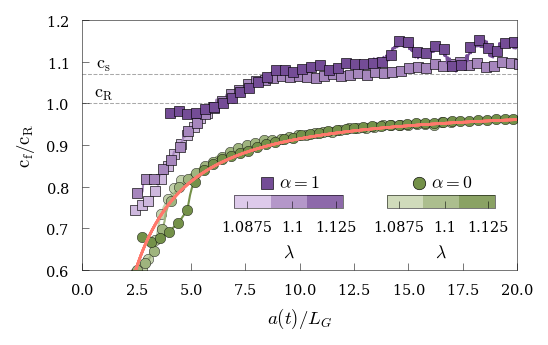

In [24]:
Z = [[0,0],[0,0]]
levels = np.asarray([0.08, 0.0875, 0.1, 0.125])
CS_greens = plt.contourf(Z, levels, cmap=cmap_greens)
CS_blues = plt.contourf(Z, levels, cmap=cmap_blues)
plt.clf()

from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.3f}'.format(x)

# plot
fig = plt.figure(figsize=set_size( width='one-column'), constrained_layout=True)

gs = fig.add_gridspec(1, 1, wspace=0.01, hspace=0.0001)
ax = fig.add_subplot(gs[0, 0])

for strain in strains:
    plot_tip_speed(ax, results=results['large'][strain], job_id=job_id['large'][strain], 
                   color=cmap_blues( (strain - np.min(levels)) /(np.max(levels)- np.min(levels) )), strain=strain, deform='large', 
                    marker='s', markerfacecolor=cmap_blues( (strain - np.min(levels)) /(np.max(levels)- np.min(levels) )), 
                    markeredgecolor='k', markeredgewidth=0.3, markevery=10, ms=4.5)
    plot_tip_speed(ax, results=results['small'][strain], job_id=job_id['small'][strain], 
                   color=cmap_greens( (strain - np.min(levels)) /(np.max(levels)- np.min(levels) )), strain=strain, deform='small', 
                    markerfacecolor=cmap_greens( (strain - np.min(levels)) /(np.max(levels)- np.min(levels) )), markevery=10)
    
    
ax.set_xlabel(r'$ a(t)/L_G$')
ax.set_ylabel(r'$\mathrm{c_f/c_R}$')
ax.set_ylim(bottom=0.6, top=1.2)
ax.set_xlim(right=20)
ax.text(10, 0.81, r'$\alpha=1$', horizontalalignment='center',
     verticalalignment='center', transform=ax.transData, fontsize=8.5)
ax.text(17, 0.81, r'$\alpha=0$', horizontalalignment='center',
     verticalalignment='center', transform=ax.transData, fontsize=8.5)
ax.plot(8.5, 0.81, marker='s', markeredgecolor='k', markerfacecolor=cmap_blues( (strain - np.min(levels)) /(np.max(levels)- np.min(levels) )),   markersize=6, markeredgewidth=0.3)
ax.plot(15.5, 0.81, marker='o', markeredgecolor='k', markerfacecolor=cmap_greens( (strain - np.min(levels)) /(np.max(levels)- np.min(levels) )),   markersize=6, markeredgewidth=0.3)

ax.axhline(1,color='darkgrey',ls='--', lw=0.5, zorder=1)
ax.axhline(matprop[sm.smd.cs]/matprop[sm.smd.cR], color='darkgrey', ls='--', lw=0.5, zorder=1)
ax.text(1, 1.095, r'$\mathrm{c_s}$', color='k', horizontalalignment='center',
         verticalalignment='center', transform=ax.transData, fontsize=8.5)
ax.text(1, 1.025, r'$\mathrm{c_R}$', color='k', horizontalalignment='center',
         verticalalignment='center', transform=ax.transData, fontsize=8.5)
 

axins1 = ax.inset_axes([0.35, 0.25, 0.25, 0.05])

cl = fig.colorbar(CS_blues, cax=axins1, pad=0.05,  format=FuncFormatter(fmt),
                  fraction=0.025, shrink=0.5, orientation="horizontal")
cl.set_label(r'$\lambda$', fontsize=8.5)

tick_locator = ticker.MaxNLocator(nbins=3)
cl.locator = tick_locator
cl.update_ticks()
cl.set_ticks(np.asarray([0.0825, 0.095, 0.12]))
cl.set_ticklabels(["1.0875", "1.1", "1.125"])


axins2 = ax.inset_axes([0.7, 0.25, 0.25, 0.05])

cl = fig.colorbar(CS_greens, cax=axins2, pad=0.05,  format=FuncFormatter(fmt),
                  fraction=0.025, shrink=0.5, orientation="horizontal")
cl.set_label(r'$\lambda$', fontsize=8.5)
tick_locator = ticker.MaxNLocator(nbins=3)
cl.locator = tick_locator
cl.update_ticks()
cl.set_ticks(np.asarray([0.0825, 0.095, 0.12]))
cl.set_ticklabels(["1.0875", "1.1", "1.125"])
plt.show()

## Poynting snapshots

In [23]:
import pyvista as pv
pv.global_theme.trame.server_proxy_enabled = True
pv.start_xvfb()

In [24]:
df = schema.showParametericSpace(shell_display=False)
df.loc[:, ~df.columns.isin(['path', 'schema'])]

E  Gamma  alpha deformations  height_factor  \
0  106000.0   15.0  200.0        small           20.0   
1  106000.0   15.0  200.0        small           20.0   
2  106000.0   15.0  200.0        large           20.0   
3  106000.0   15.0  200.0        small           20.0   
4  106000.0   15.0  200.0        small           20.0   
5  106000.0   15.0  200.0        large           20.0   
6  106000.0   15.0  200.0        large           20.0   
7  106000.0   15.0  200.0        small           20.0   
8  106000.0   15.0  200.0        large           20.0   
9  106000.0   15.0  200.0        large           20.0   

                                idx  length_factor material_law        mesh  \
0  049532e680274b87aa3fde8eedc1839d           20.0       linear  structured   
1  5889032b9deb4ed1b4901ac10a6022b7           30.0       linear  structured   
2  066ed38ecbe3408cb753a7e77d2a4101           30.0       linear  structured   
3  45b696de5f8d4aad87e67c83c18c7787           30.0       linear  structured   
4  839d951acd36412e8a26056a5938ed78           20.0       linear  structured   
5  b412ff48e49f450f8f53e9907081c329           20.0       linear  structured   
6  c22e0003e41f41aa95aac041c43dd0b7           30.0       linear  structured   
7  323dd500dd7748bf851dda810b4fb7e1           30.0       linear  structured   
8  86fbb386be09413eace51989c6855934           30.0       linear  structured   
9  471469d9f0dd47da9ad18c7673f02eb0           20.0       linear  structured   

   nb_elem_coh  poisson  prefactor  prestrain     rho  sigma_c  time  \
0         20.0     0.35        1.0     0.0800  1025.0  20000.0  0.06   
1         30.0     0.35        1.0     0.1250  1025.0  20000.0  0.06   
2         20.0     0.35        1.0     0.1250  1025.0  20000.0  0.06   
3         20.0     0.35        1.0     0.1000  1025.0  20000.0  0.06   
4         20.0     0.35        1.0     0.0875  1025.0  20000.0  0.06   
5         20.0     0.35        1.0     0.0800  1025.0  20000.0  0.06   
6         20.0     0.35        1.0     0.1000  1025.0  20000.0  0.06   
7         20.0     0.35        1.0     0.1250  1025.0  20000.0  0.06   
8         30.0     0.35        1.0     0.1250  1025.0  20000.0  0.06   
9         20.0     0.35        1.0     0.0875  1025.0  20000.0  0.06   

   time_factor  
0         0.05  
1         0.05  
2         0.05  
3         0.05  
4         0.05  
5         0.05  
6         0.05  
7         0.05  
8         0.05  
9         0.05

In [25]:
deformations = ['large', 'small']
job_id = {}
for deform in deformations:
    job_id[deform] = schema.job.digID({'poisson' : 0.35, 'sigma_c' : 2e4, 'length_factor' :30, 
                           'prestrain' : 0.125, 'prefactor' :1, 'nb_elem_coh' : 30,
                           'deformations' : deform, 'material_law' : 'linear',
                           'time_factor' : 0.05, 'alpha' : 200,
                           'mesh' : 'structured'})[0]
    schema.job.showDatabaseSpace(job_id[deform], shell_display=True)

Data Quantities in for Job | 86fbb386be09413eace51989c6855934 
+----+-------------+------------------+------------------+-------------+-----------------+---------------+-----------+----------------+-------------+--------------------+---------------------+
|    | coords.x    | energy.elastic   | energy.kinetic   | gap.ctod    | gap.effective   | gap.maximum   | timings   | tip.cohesive   | tip.crack   | tractions.actual   | tractions.applied   |
|----+-------------+------------------+------------------+-------------+-----------------+---------------+-----------+----------------+-------------+--------------------+---------------------|
|  0 | float64     | float64          | float64          | float64     | float64         | float64       | float64   | float64        | float64     | float64            | float64             |
|  1 | (190854, 0) | (190854,)        | (190854,)        | (190854, 0) | (190854, 0)     | (190854, 0)   | (190854,) | (190854, 0)    | (190854, 0) | (190854, 0)    

In [26]:
schema.job.steps_to_retrive = list(range(5000, 100000, 1))
dumping_skip = 10
readers = {}
timings = {}
speeds = {}
results = {}

output_fields = ['coords.x',  'timings', 'tip.cohesive', 'tip.crack']

for key, value in job_id.items():
    timings[key] = schema.job.digQuantitiesForJob(['timings'], value, copy=False)['timings']
    readers[key] = pv.get_reader(schema.job.path + schema.job.schema + '/' + value + '/output.xdmf')
    readers[key].set_active_time_value(timings[key][::dumping_skip][-1])
    results[key] = schema.job.digQuantitiesForJob(output_fields, value, copy=False)
    speeds[key] = get_tip_speed(results=results[key], job_id=value)

 - RUPTURE HUNTER
   * Load
     * Position 714/714
   * Hunt
 - RUPTURE HUNTER
   * Load
     * Position 714/714
   * Hunt


In [38]:
def plot_poynting_vectors(ax, _timings, _readers, _speeds, _job_id, _time_step, deformation_type='small'):
    dumping_skip=10
    time_step = _timings[deformation_type][::dumping_skip][_time_step]
    _readers[deformation_type].set_active_time_value(time_step)

    matprop = sm.LinearElasticMaterial({sm.smd.E:  schema.job.digParameterValue('E', _job_id[deformation_type]), 
                                    sm.smd.nu: schema.job.digParameterValue('poisson', _job_id[deformation_type]), 
                                    sm.smd.rho: schema.job.digParameterValue('rho', _job_id[deformation_type]), 
                                    sm.smd.pstress:False})
    
    crack_speed = _speeds[deformation_type][np.where(_speeds[deformation_type][:, 1] > time_step)[0][0], 2]
    crack_position = _speeds[deformation_type][np.where(_speeds[deformation_type][:, 1] > time_step)[0][0], 0]

    _grid = _readers[deformation_type].read()
    _grid.point_data['Poynting']= _grid.point_data['Poynting cauchy']
    _grid.point_data['Poynting'][:, 0] = _grid.point_data['Poynting cauchy'][:, 0] + (_grid.point_data['Energy density'] + _grid.point_data['Kinetic density'])*crack_speed
    _grid.point_data['Poynting mag'] = np.sqrt(_grid.point_data['Poynting'][:, 0]**2 + _grid.point_data['Poynting'][:, 1]**2)

    poynting_vector = 'Poynting' #Poynting cauchy
    # Griffith's length
    griffiths_length = get_griffiths_length(_job_id[deformation_type])

    bounds = [crack_position-2.5*griffiths_length, crack_position+2.5*griffiths_length,
              -2.5*griffiths_length, 2.5*griffiths_length, 0, 0]


    clipped = _grid.clip_box(bounds, invert=False)
    
    x = (clipped.points[:, :2] - [crack_position, 0])/griffiths_length
    u = clipped.point_data[poynting_vector]
    u0 = clipped.point_data['Poynting mag']
    
    from scipy.interpolate import griddata
    import matplotlib.tri as mtri
    
    xx = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), num=99)
    yy = np.linspace(np.min(x[:, 1]), np.max(x[:, 1]), num=99)
    
    grid_x, grid_y = np.meshgrid(xx, yy)

    grid_u0 = griddata(x, u[:, 0], (grid_x, grid_y), method='nearest')
    grid_u1 = griddata(x, u[:, 1], (grid_x, grid_y), method='nearest')

    grid_u = griddata(x, u0, (grid_x, grid_y), method='nearest')
    grid_u = np.ma.array(grid_u, mask=np.isnan(grid_u))
   
    import matplotlib
    cmap = mpl.cm.get_cmap("Spectral").copy()
    cmap.set_bad(color='white')
    print(np.min(grid_u), np.max(grid_u))
    
    cb = ax.imshow(grid_u/1e3, cmap=cmap, extent=[np.min(grid_x), np.max(grid_x), np.min(grid_y), np.max(grid_y)], vmax=50, vmin=0)
    
    step = 4
    ax.quiver(grid_x[::step, ::step], grid_y[::step, ::step], grid_u0[::step, ::step], grid_u1[::step, ::step],units='xy')
    return cb

In [28]:
def compute_energy_flow(_dt, timings, _readers, _speeds, _job_id, time_step, deformation_type='small'):
    dumping_skip = 10
    _readers[deformation_type].set_active_time_value(time_step)

    matprop = sm.LinearElasticMaterial({sm.smd.E:  schema.job.digParameterValue('E', _job_id[deformation_type]), 
                                    sm.smd.nu: schema.job.digParameterValue('poisson', _job_id[deformation_type]), 
                                    sm.smd.rho: schema.job.digParameterValue('rho', _job_id[deformation_type]), 
                                    sm.smd.pstress:False})
    
    crack_speed = _speeds[deformation_type][np.where(_speeds[deformation_type][:, 1] > time_step)[0][0], 2]
    crack_position = _speeds[deformation_type][np.where(_speeds[deformation_type][:, 1] > time_step)[0][0], 0]

    _grid = _readers[deformation_type].read()
    points = _grid.points - np.asarray([crack_speed, 0, 0])
    
    poynting_vector = _grid.point_data['Poynting cauchy']
    poynting_vector[:, 0] += (_grid.point_data['Energy density'] + _grid.point_data['Kinetic density'])*crack_speed
    
    radius = 2*get_griffiths_length(_job_id[deformation_type])
    thetas =  np.linspace(0, 2*np.pi, num=50)
    dtheta = thetas[1] - thetas[0]
    ds = radius*dtheta
    
    coords = np.zeros(( len(thetas), 2))
    coords[:, 0] = radius*np.cos(thetas)
    coords[:, 1] = radius*np.sin(thetas)
    
    integrated_value = 0
    for coord in coords:
        index = np.argmin(np.hypot(points[:, 0]-coord[0], points[:, 1] - coord[1]))
        normal = coord/np.hypot(coord[0], coord[1])
        integrated_value += np.dot(poynting_vector[index, :2], normal)*ds*dt
        
    return integrated_value

In [60]:
time_step_1 =4000
time_step_2 = 500
time_step_3 = 2250

0.935497954273362 2
-277368.03 782314.75
33.535545 163815.44
0.9378061160175011 2
-113300.05 101576.93
372.42383 23026.41
1.0424926462459285 2
-279950.88 361349.62
11.569581 77630.77
 - RUPTURE HUNTER
   * Load
     * Position 714/714
   * Hunt
 - RUPTURE HUNTER
   * Load
     * Position 714/714
   * Hunt


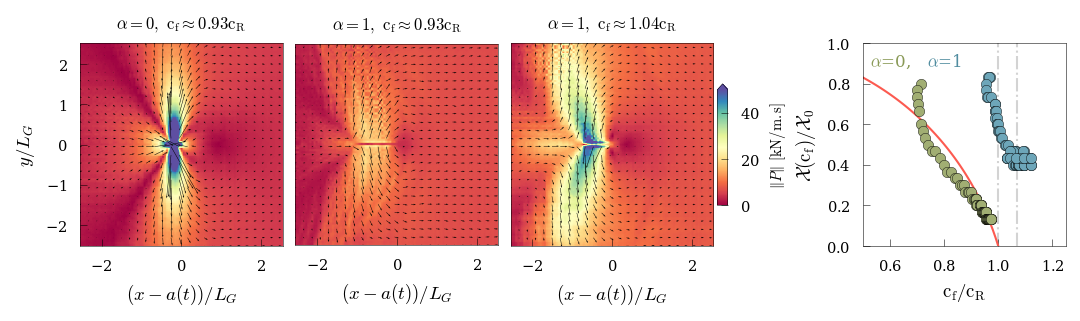

In [61]:
fig = plt.figure(figsize=set_size( width='two-column', height_ratio='golden'), constrained_layout=True)
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1,1])
ax = fig.add_subplot(gs[0, 0])
cb = plot_poynting_vectors(ax, timings, readers, speeds, job_id, _time_step=time_step_1, 
                      deformation_type='small')
ax.set_xlabel(r'$ (x-a(t))/L_G$')
ax.set_ylabel(r'$y/L_G$')
ax.text(0, 3, r'$\alpha=0,~\mathrm{c_f}\approx0.93\mathrm{c_R}$',
            color='k', horizontalalignment='center',
     verticalalignment='center', transform=ax.transData, fontsize=8)
ax.set_aspect(1./ax.get_data_ratio())
ax = fig.add_subplot(gs[0, 1])
cb = plot_poynting_vectors(ax, timings, readers, speeds, job_id, _time_step=time_step_2, 
                      deformation_type='large')
ax.set_xlabel(r'$ (x-a(t))/L_G$')
ax.axes.get_yaxis().set_visible(False)
ax.text(0, 3, r'$\alpha=1,~\mathrm{c_f}\approx0.93\mathrm{c_R}$',
            color='k', horizontalalignment='center',
     verticalalignment='center', transform=ax.transData, fontsize=8)

ax = fig.add_subplot(gs[0, 2])
cb = plot_poynting_vectors(ax, timings, readers, speeds, job_id, _time_step=time_step_3, 
                      deformation_type='large')
ax.set_xlabel(r'$ (x-a(t))/L_G$')
ax.axes.get_yaxis().set_visible(False)
ax.text(0, 3, r'$\alpha=1,~\mathrm{c_f}\approx1.04\mathrm{c_R}$',
            color='k', horizontalalignment='center',
     verticalalignment='center', transform=ax.transData, fontsize=8)
ax.set_aspect(1./ax.get_data_ratio())
axins1 = ax.inset_axes([1.02, 0.2, 0.05, 0.6])

cbar = fig.colorbar(cb, cax=axins1, pad=0.05, extend='max', 
                      fraction=0.025, shrink=.5, orientation="vertical")
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label(r'$\| P \|~\mathrm{[kN/m.s]}$', fontsize=7)#, x=1.25, y=0.5, transform=ax.transAxes)

#cbar.ax.yaxis.set_offset_position('right')

ax = fig.add_subplot(gs[0, 3])
colors = {}
colors['small'] = cmap_greens(0.3)
colors['large'] = cmap_blues(0.3)

for deform in deformations:
    speed, size = plot_cohesive_zone_size(ax, results=results[deform], job_id=job_id[deform], color=colors[deform], deform=deform)
    '''if deform == 'small':
        index = np.argwhere(speed > 0.93)[0][0]
        print(index, size[index])
        ax.scatter(0.93, size[index], c=cmap_greens(1.0), zorder=20)
    if deform == 'large':
        index = np.argwhere(speed > 0.93)[0][0]
        ax.scatter(0.93, size[index], c=cmap_blues(0.7), zorder=20)
        index = np.argwhere(speed > 1.04)[0][0]
        ax.scatter(1.04, size[index], c=cmap_blues(1.0), zorder=20)'''
    
ax.set_ylabel(r'$ \mathcal{X}(\mathrm{c_f})/\mathcal{X}_0$')
ax.set_xlabel(r'$\mathrm{c_f/c_R}$')
ax.set_xlim(left=0.5, right=1.25)
ax.set_ylim(0, 1)
ax.set_aspect(1./ax.get_data_ratio())

ax.text(0.6, 0.91, r'$\alpha$=0,', color=cmap_greens(0.5), horizontalalignment='center',
     verticalalignment='center', transform=ax.transData, fontsize=8)
ax.text(0.8, 0.91, r'$\alpha$=1', color=cmap_blues(0.5), horizontalalignment='center',
     verticalalignment='center', transform=ax.transData, fontsize=8)

plt.show()